# Concurso de Modelización de problemas de empresas

## Interpretabilidad en riesgo de crédito.
### Management solutions.

La variable dependiente que se desea analizar es el “loan_status”. Dicha variable representa la probabilidad de impago de un cliente de una entidad financiera (donde el valor 1 representa impago).Las variables explicativas son:

- person_age: edad de la persona 
- person_income: el ingreso personal se refiere a las ganancias totales de un individuo provenientes de salarios, empresas de inversión y otras empresas.
- person_home_ownership: esta variable indica el tipo de posesión de una persona sobre su casa. Puede tomar el valor RENT = alquiler, OWN = en propiedad y MORTAGE = con hipoteca.
- person_emp_length: variable que indica los años que lleva trabajando una persona.
- loan_intent: variable que indica el propósito/ intención del préstamo.
- loan_grade: variable resultante de aplicar una fórmula que tiene en cuenta no solo el creditscore (puntuaje de crédito) sino tambien varios indicadores de riesgo de crédito extraidos del informe de crédito y solicitud de préstamo.
- loan_amnt: cantidad de crédito solicitado.
- loan_int_rate: tasas de interes de préstamo (en porcentaje)
- loan_percent_income: variable que mide el porcentaje de la relación deuda-ingreso (DTI), que es el porcentaje de su ingreso mensual bruto gastado en pagos de deuda. Este número se calcula dividiendo los costos totales de la deuda por mes por el ingreso mensual bruto del prestatario.
- cb_person_default_on_file: variable binaria que inidca si la persona no ha devuelto algun prestamo.
- cb_person_cred_hist_length: historia crediticia de la persona.
- loan_status: estado del préstamo 


## Librerías y paquetes

In [1]:
import operator as opt
import numpy as np 
from numpy import loadtxt
from pylab import *
import pandas as pd 
import os
import gc
from contextlib import contextmanager
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats

warnings.filterwarnings('ignore')           
%matplotlib inline     
sns.set(color_codes=True)

# 1. Analisis exploratorio de los datos 

In [2]:
#train = pd.read_csv("UCM2022_Management_Solutions/UCM2022_Management_Solutions/train.csv")
#train = pd.read_csv("D:/Usuarios/Mario Neta/AppData/Local/Programs/Python/Python38/Scripts/modelizacion/train.csv")
train = pd.read_csv("train.csv")
train.head(5)  

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,25,59000,MORTGAGE,6.0,MEDICAL,A,5100,8.32,0.09,N,3,0
1,35,26400,RENT,2.0,DEBTCONSOLIDATION,D,6000,16.29,0.23,Y,8,1
2,33,45000,RENT,13.0,EDUCATION,C,6800,11.22,0.15,Y,6,1
3,27,144000,MORTGAGE,4.0,DEBTCONSOLIDATION,C,21000,13.57,0.15,Y,8,0
4,31,43200,RENT,NaN,MEDICAL,B,1000,10.74,0.02,N,9,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24435 entries, 0 to 24434
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  24435 non-null  int64  
 1   person_income               24435 non-null  int64  
 2   person_home_ownership       24435 non-null  object 
 3   person_emp_length           23759 non-null  float64
 4   loan_intent                 24435 non-null  object 
 5   loan_grade                  24435 non-null  object 
 6   loan_amnt                   24435 non-null  int64  
 7   loan_int_rate               22061 non-null  float64
 8   loan_percent_income         24435 non-null  float64
 9   cb_person_default_on_file   24435 non-null  object 
 10  cb_person_cred_hist_length  24435 non-null  int64  
 11  loan_status                 24435 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.2+ MB


Con un primer vistazo ya podemos observar que hay datos faltantes (missings) en las variables person_emp_length y loan_int_rate

## 1. Datos duplicados.


In [3]:
duplicate_rows_train = train[train.duplicated()]
print("numero de duplicados: ", duplicate_rows_train.shape)
duplicate_rows_train.head(5)  
train = train.drop_duplicates()

numero de duplicados:  (88, 12)


## 2. Datos missings.

In [4]:
train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              672
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2363
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

Hemos considerado que los missings de la variable person_emp_length los imputaremos por la mediana ya que son 'pocos'. Mientras que en la variable loan_int_rate eliminaremos las observaciones con missings dado que la variable es muy importante en nuestro estudio y no se puede imputar o estimar.

In [5]:
# Reemplazar los missings de la variable person_emp_length

median = train['person_emp_length'].median()      # calculamos la mediana
print('la mediana es :', median)
train['person_emp_length'].fillna(median, inplace=True)  # imputamos el valor


la mediana es : 4.0


In [6]:
# Quitamos los missings de la variable loan_int_rate

indices = train[train['loan_int_rate'].isnull()].index
train_clean = train.drop(indices)


train_clean es la nueva base de datos sin duplicados ni missings.

## 3. Tratamiento de Outliers.

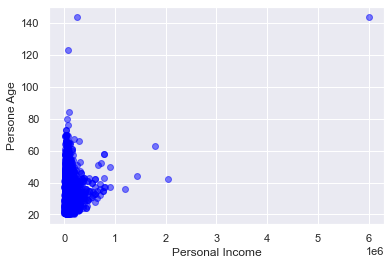

In [8]:
# Gráfico de Ingresos frente a la edad por persona.
plt.scatter(train_clean['person_income'], train_clean['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

En este gráfico se puede ver claramente una nube de puntos a la izquierda y tres posibles outliers. De hecho, son personas que tienen mas de 100 años (que es raro) y con ingresos muy altos lo que nos hace sospechar aún mas. 

In [7]:
# quitamos las personas que tienen mas de 100 años 
#train_new es train_clean sin las personas de más de cien años

train_new = train_clean.drop(train_clean[train_clean['person_age'] > 100].index)
train_new = train_new.drop(train_new[train_new['person_income'] > 1000000].index)
train_new = train_new.drop(train_new[train_new['person_emp_length'] > 40].index)

Text(0.5, 1.0, 'loan_amnt')

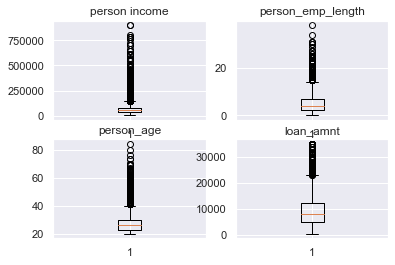

In [8]:
figure(1)

subplot(221)
boxplot(train_new['person_income'])
title('person income')
subplot(222)
boxplot(train_new['person_emp_length'])
title('person_emp_length')
subplot(223)
boxplot(train_new['person_age'])
title('person_age')
subplot(224)
boxplot(train_new['loan_amnt'])
title('loan_amnt')


Text(0.5, 1.0, 'cb_person_cred_hist_length')

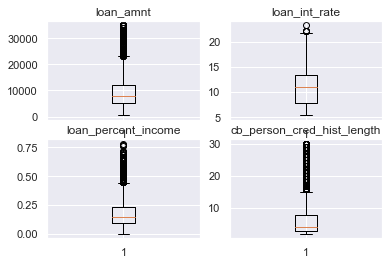

In [9]:
figure(2)
subplot(221)
boxplot(train_new['loan_amnt'])
title('loan_amnt')
subplot(222)
boxplot(train_new['loan_int_rate'])
title('loan_int_rate')
subplot(223)
boxplot(train_new['loan_percent_income'])
title('loan_percent_income')
subplot(224)
boxplot(train_new['cb_person_cred_hist_length'])
title('cb_person_cred_hist_length')



## 4. Escalar los datos.

In [10]:

scaler = StandardScaler() # Funcion para escalar

# funcion que coge los datos tipo numerico y los escala
def escalar_datos (x):
    X_train_numeric = x.select_dtypes(exclude = 'object')   #seleccionamos los datos numericos
    X_train_numeric = X_train_numeric.drop(['loan_status'],axis=1)
    X_numeric_cols = X_train_numeric.columns
    X_train_numeric.columns = X_numeric_cols
    # ahora escalamos los datos numericos
    X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train_numeric))
    X_train_numeric.set_index(x.index, inplace = True)
    X_train_numeric.columns = X_numeric_cols
    return X_train_numeric
    

In [11]:
X_train_numeric = escalar_datos(train_new)
X_train_numeric.head(5)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,-0.440202,-0.142286,0.303754,-0.707965,-0.826019,-0.748453,-0.695433
1,1.184193,-0.839133,-0.697970,-0.566292,1.628690,0.560834,0.547522
2,0.859314,-0.441545,2.056771,-0.440360,0.067163,-0.187330,0.050340
3,-0.115323,1.674644,-0.197108,1.794927,0.790948,-0.187330,0.547522
4,0.534435,-0.480022,-0.197108,-1.353365,-0.080674,-1.403097,0.796114


## 5. One hot encoging (dummificar los datos)

In [12]:
#funcion para dummificar 
def dummificar(x):
    X_train_cat = x.select_dtypes(include = 'object') # selecciona las vbles tipo object
    #dumificar:
    X_train_cat = pd.get_dummies(x, columns=['person_home_ownership'], prefix='', prefix_sep='') 
    X_train_cat = pd.get_dummies(X_train_cat, columns=['loan_intent'], prefix='', prefix_sep='')
    X_train_cat = pd.get_dummies(X_train_cat, columns=['loan_grade'], prefix='', prefix_sep='') 
    X_train_cat = pd.get_dummies(X_train_cat, columns=['cb_person_default_on_file'], prefix='', prefix_sep='') 
    # le ponemos nombre a las variables:
    X_train_ = X_train_cat[['MORTGAGE','OTHER','OWN','RENT', 'DEBTCONSOLIDATION','EDUCATION','HOMEIMPROVEMENT','MEDICAL','PERSONAL','VENTURE','A','B','C','D','E','F','G','N','Y']]
    return X_train_


In [13]:
X_train_dummi = dummificar(train_new)
X_train_dummi.head(5)

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,A,B,C,D,E,F,G,N,Y
0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [14]:
# finalmente juntamos las variables dummificadas y las escaladas en un mismo
# dataframe llamado train_listo

def juntar_variables (x):
    X_train_dummi = pd.merge(dummificar(x),x.loan_status,left_index = True, right_index = True)
    train = pd.merge(X_train_dummi, escalar_datos(x), left_index = True, right_index = True)
    return train

train_listo = juntar_variables(train_new)
train_listo.head(5)

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,N,Y,loan_status,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,-0.440202,-0.142286,0.303754,-0.707965,-0.826019,-0.748453,-0.695433
1,0,0,0,1,1,0,0,0,0,0,...,0,1,1,1.184193,-0.839133,-0.697970,-0.566292,1.628690,0.560834,0.547522
2,0,0,0,1,0,1,0,0,0,0,...,0,1,1,0.859314,-0.441545,2.056771,-0.440360,0.067163,-0.187330,0.050340
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,-0.115323,1.674644,-0.197108,1.794927,0.790948,-0.187330,0.547522
4,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0.534435,-0.480022,-0.197108,-1.353365,-0.080674,-1.403097,0.796114


## 6. Matriz de correlaciones.

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,N,Y,loan_status,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
MORTGAGE,1.000000,-0.043543,-0.249607,-0.843925,0.026418,-0.002502,0.048086,-0.055757,0.016000,-0.021658,...,0.060897,-0.060897,-0.186244,0.037785,0.269264,0.226911,0.139008,-0.130622,-0.146502,0.026372
OTHER,-0.043543,1.000000,-0.015432,-0.052177,0.003949,-0.010403,0.000820,-0.002047,0.004917,0.003683,...,-0.013169,0.013169,0.014961,-0.005412,0.022330,-0.008685,0.011826,0.014444,0.007387,-0.003947
OWN,-0.249607,-0.015432,1.000000,-0.299098,-0.108180,0.011787,0.009476,-0.011179,0.000453,0.094414,...,0.005777,-0.005777,-0.107901,-0.006491,-0.050309,0.025619,-0.026174,-0.014532,0.052181,0.000359
RENT,-0.843925,-0.052177,-0.299098,1.000000,0.032696,-0.002901,-0.052622,0.061233,-0.016514,-0.030651,...,-0.061769,0.061769,0.240843,-0.033104,-0.240000,-0.236575,-0.123821,0.135090,0.115000,-0.025760
DEBTCONSOLIDATION,0.026418,0.003949,-0.108180,0.032696,1.000000,-0.216182,-0.155469,-0.206741,-0.195094,-0.200911,...,0.000104,-0.000104,0.073243,-0.002729,0.000408,-0.000616,-0.003492,0.001885,0.005617,-0.006474
EDUCATION,-0.002502,-0.010403,0.011787,-0.002901,-0.216182,1.000000,-0.178258,-0.237046,-0.223691,-0.230361,...,0.009297,-0.009297,-0.059404,-0.094322,-0.018598,-0.038207,-0.011356,-0.010315,-0.004571,-0.078259
HOMEIMPROVEMENT,0.048086,0.000820,0.009476,-0.052622,-0.155469,-0.178258,1.000000,-0.170474,-0.160869,-0.165666,...,-0.005871,0.005871,0.035200,0.077290,0.066067,0.032055,0.039041,0.012536,-0.020125,0.060620
MEDICAL,-0.055757,-0.002047,-0.011179,0.061233,-0.206741,-0.237046,-0.170474,1.000000,-0.213923,-0.220301,...,-0.004377,0.004377,0.059233,0.015711,-0.049185,-0.004707,-0.027040,0.012145,0.011781,0.012397
PERSONAL,0.016000,0.004917,0.000453,-0.016514,-0.195094,-0.223691,-0.160869,-0.213923,1.000000,-0.207890,...,-0.004440,0.004440,-0.023109,0.032974,0.010683,0.009356,0.003433,0.001316,-0.003204,0.031847
VENTURE,-0.021658,0.003683,0.094414,-0.030651,-0.200911,-0.230361,-0.165666,-0.220301,-0.207890,1.000000,...,0.003870,-0.003870,-0.074992,-0.011347,0.003675,0.009511,0.006896,-0.015108,0.007303,-0.006213


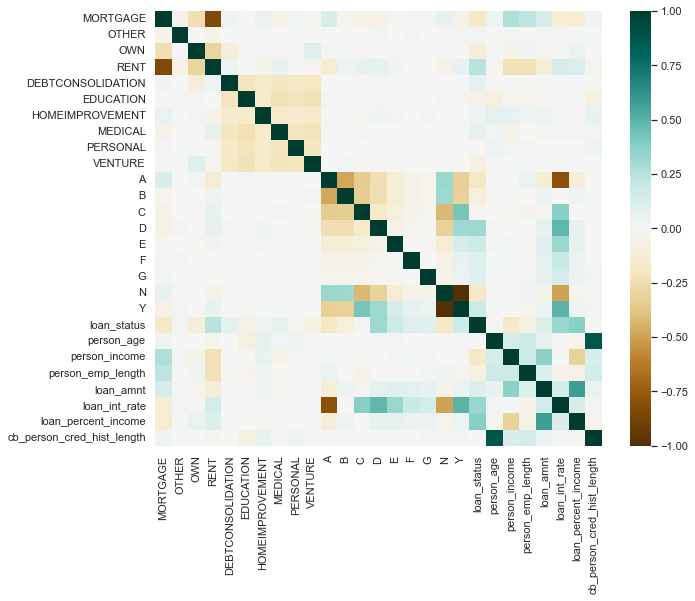

In [16]:
plt.figure(figsize=(10,8))
correlaciones = train_listo.corr()
sns.heatmap(correlaciones,cmap="BrBG")
correlaciones

Se puede ver claramente una gran correlacion entre 'cb_person_cred_hist_length' y 'person_age' esto tiene una explicacion clara ya que a medida que la edad aumenta el historial de creditos es mayor . Tambien entre 'loan_amnt' y 'loan_percent_income es una relacion directa como hemos explicado arriba.

Tambien deberíamos estudiar la relacion que existe entre 'loan_percent_income'+'loan_int_rate' con 'loan_status'. 

# 2. Modelos 

# Árbol de decision.


In [18]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [19]:
y_trainAD = train_listo[['loan_status']]
x_trainAD = train_listo.drop(['loan_status'],axis=1)

In [20]:
x_trainAD, x_testAD, y_trainAD, y_testAD = train_test_split(x_trainAD, y_trainAD,random_state=42, test_size=.30)

In [21]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_trainAD,y_trainAD)
y_predAD = clf.predict(x_testAD)
preds_proba = clf.predict_proba(x_testAD)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_testAD, prob_default)
print(f'ROC AUC Score: {100*auc}%')

ROC AUC Score: 84.83080757572193%


## 2. Optimización de hiperparametros

In [22]:
from sklearn.model_selection import GridSearchCV
tree_para = {'criterion':['gini','entropy'],'max_depth':[10,11,12,13,15,24,30,35], 'random_state':[11,12,20,30,40,42,50]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf = clf.fit(x_trainAD,y_trainAD)
y_predAD = clf.predict(x_testAD)
preds_proba = clf.predict_proba(x_testAD)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_testAD, prob_default)
print(f'ROC AUC Score: {100*auc}%')

ROC AUC Score: 90.77126700922203%


# Regresión Logística

In [23]:
from sklearn.linear_model import LinearRegression

y_train = train_listo[['loan_status']]
x_train = train_listo.drop(['loan_status'],axis=1)
y_train = y_train.loc[x_train.index]
#x_train, x_test, y_train, y_test = train_test_split(x_Train, y_Train,random_state=42, test_size=.30)
x_test = test_sol_listo
y_test = solution_template['binar']



In [24]:
#C=14.563484775012444
lr = LogisticRegression()

# entrenamos el modelo 
lr.fit(x_train, y_train)
# predecimos 
preds = lr.predict(x_test)
preds_proba = lr.predict_proba(x_test)

print(lr, '\n',classification_report(y_test, lr.predict(x_test)))

LogisticRegression() 
               precision    recall  f1-score   support

           0       0.51      0.84      0.63      4137
           1       0.49      0.16      0.24      4009

    accuracy                           0.50      8146
   macro avg       0.50      0.50      0.44      8146
weighted avg       0.50      0.50      0.44      8146



In [25]:
### METRICA AUC
from sklearn.metrics import roc_curve, roc_auc_score

prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(f'ROC AUC Score: {100*auc}%')

ROC AUC Score: 50.114372827924704%


Un valor de la métrica AUC se considera bueno si es mayor que 0.7 luego este valor no esta nada mal. Sin embargo vamos a intentar mejorarlo primero con feature engineering y despues con la optimización de los hiperparámetros.

## 1. Feature engineering para Regresion Logistica.

In [26]:
# crear una lista con todas las cominaciones posibles de pares de variables.
from itertools import combinations
column_list = x_train.columns
interactions = list(combinations(column_list, 2))


# Iterate through interaction list to perform linear regression for each possible engineered features
interaction_dict = {}
for interaction in interactions:
    X_train_int = x_train
    X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
    lr3 = LinearRegression()
    lr3.fit(X_train_int, y_train)
    interaction_dict[roc_auc_score(y_test, prob_default)] = interaction
    
top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction_dict[interaction])   

('loan_percent_income', 'cb_person_cred_hist_length')


In [30]:
X_train_int = x_train
X_train_int['cred_loan'] = X_train_int['loan_percent_income'] * X_train_int['cb_person_cred_hist_length']
x_test_int= x_test
X_train_int = X_train_int.drop(['int'], axis=1)
x_test_int['cred_loan'] = x_test_int['loan_percent_income'] * x_test_int['cb_person_cred_hist_length']


In [31]:
X_train_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21975 entries, 0 to 24434
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MORTGAGE                    21975 non-null  uint8  
 1   OTHER                       21975 non-null  uint8  
 2   OWN                         21975 non-null  uint8  
 3   RENT                        21975 non-null  uint8  
 4   DEBTCONSOLIDATION           21975 non-null  uint8  
 5   EDUCATION                   21975 non-null  uint8  
 6   HOMEIMPROVEMENT             21975 non-null  uint8  
 7   MEDICAL                     21975 non-null  uint8  
 8   PERSONAL                    21975 non-null  uint8  
 9   VENTURE                     21975 non-null  uint8  
 10  A                           21975 non-null  uint8  
 11  B                           21975 non-null  uint8  
 12  C                           21975 non-null  uint8  
 13  D                           219

In [45]:
# Add the top two interaction features (which exclude a categorical variable) to existing DF for feature engineered model
X_train_int = x_train
X_train_int['re_loan'] = X_train_int['RENT'] * X_train_int['loan_percent_income']
X_train_int['MORTGAGE_loan'] = X_train_int['MORTGAGE'] * X_train_int['loan_percent_income']
X_train_int['DEBTCONSOLIDATION_D'] = X_train_int['DEBTCONSOLIDATION'] * X_train_int['D']
X_train_int['OWN_D'] = X_train_int['OWN'] * X_train_int['D']
X_train_int['INCOME_loan'] = X_train_int['person_income'] * X_train_int['loan_percent_income']
X_train_int = X_train_int.drop(['int'], axis=1)

x_test_int= x_test
x_test_int['re_loan'] = x_test_int['RENT'] * x_test_int['loan_percent_income']
x_test_int['MORTGAGE_loan'] = x_test_int['MORTGAGE'] * x_test_int['loan_percent_income']
x_test_int['DEBTCONSOLIDATION_D'] = x_test['DEBTCONSOLIDATION'] * x_test['D']
x_test_int['OWN_D'] = x_test_int['OWN'] * x_test_int['D']
x_test_int['INCOME_loan'] = x_test_int['person_income'] * x_test_int['loan_percent_income']

Hemos conseguido mejorarlo pero todavia se puede un poco mas.

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly_dict = {}
for feature in X_train_int.columns:
    for p in range(2, 5):
        X_train_poly = X_train_int
        X_train_poly['sq'] = X_train_poly[feature] ** p
        lr = LinearRegression()
        lr.fit(X_train_poly, y_train)
        poly_dict[roc_auc_score(y_test, prob_default)] = [feature, p]
    
poly_dict[max(poly_dict.keys())]

['cred_loan', 4]

In [33]:
X_train_final = X_train_int
X_train_final['cred_loan'] = X_train_final['cred_loan'] ** 4
X_train_final=X_train_final.drop(['sq'], axis=1)

x_test_final = x_test_int
x_test_final['cred_loan'] = x_test_final['cred_loan'] ** 4

X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21975 entries, 0 to 24434
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MORTGAGE                    21975 non-null  uint8  
 1   OTHER                       21975 non-null  uint8  
 2   OWN                         21975 non-null  uint8  
 3   RENT                        21975 non-null  uint8  
 4   DEBTCONSOLIDATION           21975 non-null  uint8  
 5   EDUCATION                   21975 non-null  uint8  
 6   HOMEIMPROVEMENT             21975 non-null  uint8  
 7   MEDICAL                     21975 non-null  uint8  
 8   PERSONAL                    21975 non-null  uint8  
 9   VENTURE                     21975 non-null  uint8  
 10  A                           21975 non-null  uint8  
 11  B                           21975 non-null  uint8  
 12  C                           21975 non-null  uint8  
 13  D                           219

In [34]:
lr5 = LogisticRegression()
lr5.fit(X_train_final, y_train)
score=lr5.score(X_train_final, y_train)
print(f'Overall Accuracy: {100*score}%')

preds_proba = lr5.predict_proba(x_test_final)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(f'ROC AUC Score: {100*auc}%')

Overall Accuracy: 86.4254835039818%
ROC AUC Score: 50.097719459232195%


## 2. Optimización de hiperparámetros.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, decomposition, datasets

In [36]:

# creamos un pipeline
logistic = linear_model.LogisticRegression()
pipe = Pipeline(steps=[('logistic', logistic)])

# creamos la lista de parametros a optimizar
C = np.logspace(-3, 3, 50)
penalty = ['l1', 'l2']
parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)


GS_lr = GridSearchCV(pipe, parameters,scoring='roc_auc')

In [37]:
GS_lr.fit(X_train_final, y_train)
# View The Best Parameters
print('Best Penalty:', GS_lr.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', GS_lr.best_estimator_.get_params()['logistic__C'])
print(); print(GS_lr.best_estimator_.get_params()['logistic'])

Best Penalty: l2
Best C: 0.21209508879201905

LogisticRegression(C=0.21209508879201905)


In [38]:
# volvemos a aplicar la Regresion logistica 
lr_final=LogisticRegression(C=0.21209508879201905)
lr_final.fit(X_train_final, y_train)
preds_proba = lr_final.predict_proba(x_test_final)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(y_test, prob_default)
print(f'ROC AUC Score: {100*auc}%')

ROC AUC Score: 50.12566600662167%


Parece que este va a ser el mejor resultado de AUC que vamos a tener.

# 3. Solucion.

## Limpieza de los datos 

In [15]:
test_solution = pd.read_csv('test.csv')
solution_template = pd.read_csv('solution_template.csv')


In [16]:
test_solution.isnull().sum()

person_age                      0
person_income                   0
person_home_ownership           0
person_emp_length             219
loan_intent                     0
loan_grade                      0
loan_amnt                       0
loan_int_rate                 742
loan_percent_income             0
cb_person_default_on_file       0
cb_person_cred_hist_length      0
dtype: int64

In [17]:
solution_template.isnull().sum()

loan_status    0
dtype: int64

In [18]:
# Reemplazar los missings de la variable person_emp_length

median = test_solution['person_emp_length'].median()      # calculamos la mediana
print('la mediana es :', median)
test_solution['person_emp_length'].fillna(median, inplace=True)  # imputamos el valor
# Reemplazar los missings de la variable loan_int_rate
median = test_solution['loan_int_rate'].median()      # calculamos la mediana
print('la mediana es :', median)
test_solution['loan_int_rate'].fillna(median, inplace=True)  # imputamos el valor

la mediana es : 4.0
la mediana es : 11.03


Como no podemos eliminar los missings tal cual los estimaremos por la mediana en ambas variables 

In [19]:
# escalamos los datos numericos 
def escalar_datos_new (x):
    X_train_numeric = x.select_dtypes(exclude = 'object')   #seleccionamos los datos numericos
    X_numeric_cols = X_train_numeric.columns
    X_train_numeric.columns = X_numeric_cols
    # ahora escalamos los datos numericos
    X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train_numeric))
    X_train_numeric.set_index(x.index, inplace = True)
    X_train_numeric.columns = X_numeric_cols
    return X_train_numeric
    

X_test_sol_num = escalar_datos_new(test_solution) 
X_test_sol_num.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,-0.891359,-0.643698,-0.430504,-1.053027,0.022529,-0.663060,-0.676505
1,0.837266,0.848197,0.078885,-0.731563,0.533434,-1.227831,-0.185170
2,-0.419916,-0.463369,-0.685199,-0.860149,-0.462343,-0.663060,-0.922172
3,1.780151,0.237028,3.389914,0.875756,0.214525,0.184097,1.780167
4,-0.577063,-0.246975,-0.430504,-1.053027,-0.006759,-1.039574,-0.922172


In [20]:
X_test_sol_dummi = dummificar(test_solution)
X_test_sol_dummi.head()

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,A,B,C,D,E,F,G,N,Y
0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [21]:
def juntar (x,y):
    z = pd.merge(y,x, left_index = True, right_index = True)
    return z
test_sol_listo = juntar(X_test_sol_num,X_test_sol_dummi)
test_sol_listo.head()

,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE,...,G,N,Y,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,0,0,0,1,0,0,0,0,1,0,...,0,1,0,-0.891359,-0.643698,-0.430504,-1.053027,0.022529,-0.663060,-0.676505
1,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0.837266,0.848197,0.078885,-0.731563,0.533434,-1.227831,-0.185170
2,0,0,0,1,0,1,0,0,0,0,...,0,1,0,-0.419916,-0.463369,-0.685199,-0.860149,-0.462343,-0.663060,-0.922172
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1.780151,0.237028,3.389914,0.875756,0.214525,0.184097,1.780167
4,0,0,0,1,0,0,0,1,0,0,...,0,1,0,-0.577063,-0.246975,-0.430504,-1.053027,-0.006759,-1.039574,-0.922172


In [22]:
# tenemos que pasar el vector solution_template a binario 
binar= []
for loan_status in solution_template['loan_status']:
    if (loan_status <= 0.5) :
        binar.append(1)
    else :
        binar.append(0)
solution_template["binar"] = binar 
print(solution_template)

      loan_status  binar
0        0.853711      0
1        0.346104      1
2        0.548490      0
3        0.165105      1
4        0.266824      1
...           ...    ...
8141     0.511305      0
8142     0.427160      1
8143     0.625003      0
8144     0.693501      0
8145     0.299384      1

[8146 rows x 2 columns]


## modelos 

## 1. Regresion logistica.

In [ ]:
lr_final=LogisticRegression(C=6.25055192527397)
lr_final.fit(X_train_final, y_train)
preds_proba = lr_final.predict_proba(test_sol_listo)
prob_default = preds_proba[:, 1]
auc = roc_auc_score(solution_template['binar'], prob_default)
print(f'ROC AUC Score: {100*auc}%')

In [ ]:
print(solution_template['binar'])

In [ ]:
test_sol_listo['re_loan'] = test_sol_listo['RENT'] * test_sol_listo['loan_percent_income']
test_sol_listo['MORTGAGE_loan'] = test_sol_listo['MORTGAGE'] * test_sol_listo['loan_percent_income']
test_sol_listo['DEBTCONSOLIDATION_D'] = test_sol_listo['DEBTCONSOLIDATION'] * test_sol_listo['D']
test_sol_listo['OWN_D'] = test_sol_listo['OWN'] * test_sol_listo['D']
test_sol_listo['INCOME_loan'] = test_sol_listo['person_income'] * test_sol_listo['loan_percent_income']

test_sol_listo['edu_cubed'] = test_sol_listo['loan_amnt'] ** 2

test_sol_listo.info()

In [ ]:
preds = lr_final.predict(test_sol_listo)
preds_proba_ = lr_final.predict_proba(test_sol_listo)
auc = roc_auc_score(solution_template['binar'], preds_proba_[:,1])
print(f'ROC AUC Score: {100*auc}%')
print(lr_final, '\n',classification_report(solution_template['binar'], lr_final.predict(test_sol_listo)))

In [ ]:
print(preds_proba_)
